In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
def calculate_v_KC(v0: float, f0: float, mu_KC: float, mu_c: float, n_c: float, n_m: float, d: float, L0: float, D0: float, x_KC_minus: ArrayLike):
    """
    Calculate kinetochore speed.

    Left kinetochore position is used as independent variable. Assumes interkinetochore velocity can be neglected, i.e. 
    `v_KC_plus - v_KC_minus = 0`, which results in `x_KC_plus - x_KC_minus = d`.
    
    Parameters
    ----------
        v0 : float
            Motor velocity without load.
        f0 : float
            Stall force.
        mu_KC : float
            Effective friction coefficient at the kinetochore.
        mu_c : float
            Friction coefficient of single crosslinking protein.
        n_c : float
            Linear density of crosslinking proteins.
        n_m : float
            Linear density of motor proteins.
        d : float
            Interkinetochore distance.
        L0 : float
            Spindle length.
        D0 : float
            Bridging microtubule overlap.
        x_KC_minus : array-like
            Position of left kinetochore.

    Model paramaters calculated from arguments:
    x_KC_plus  : Position of right kinetochore (x_KC_plus = x_KC_minus + d).
    L_plus     : Lentgh of parallel overlap between plus-side k-fiber and plus-side bMT.
    L_minus    : Lentgh of parallel overlap between minus-side k-fiber and minus-side bMT.
    D_plus     : Length of antiparallel overlap between plus-side k-fiber and minus-side bMT.
    D_minus    : Lentgh of antiparallel overlap between minus-side k-fiber and plus side bMT.

    Returns
    -------
    array-like
        Kinetochore velocity array. Calculated at points specified in `x_KC_minus`.
    """

    x_KC_plus = x_KC_minus + d
    L_plus = L0/2 - x_KC_plus
    L_minus = L0/2 + x_KC_minus
    D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
    D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
    
    Nc_plus = n_c * L_plus
    Nc_minus = n_c * L_minus
    Nm_plus = n_m * D_plus
    Nm_minus = n_m * D_minus
    gc_plus = Nc_plus * mu_c
    gc_minus = Nc_minus * mu_c
    gm_plus = Nm_plus * f0/v0
    gm_minus = Nm_minus * f0/v0
    alpha_plus = (gc_plus + gm_plus + mu_KC)**(-1)
    alpha_minus = (gc_minus + gm_minus + mu_KC)**(-1)

    fac1 = 0.5 * v0/mu_KC
    num1 = (gc_plus + gm_plus) * (1 - alpha_plus * (gc_plus + gm_plus))
    num2 = (gc_minus + gm_minus) * (1 - alpha_minus * (gc_minus + gm_minus))
    den1 = alpha_plus * (gc_plus + gm_plus)
    den2 = alpha_minus * (gc_minus + gm_minus)

    num = num1 - num2
    den = den1 + den2
    fac2 = num/den

    return fac1 * fac2


def finite_difference(fun: Callable, t: ArrayLike, x0: float, args: tuple = None) -> ArrayLike:
    """
    Integrate dx/dt = f(t, x) using finite difference method.

    Parameters
    ----------
    fun : callable
        Derivative of x at time t (dx/dt(t)). Called as fun(*args, x0).
    t : array-like
        Time points to calculate x in.
    x0 : float
        Initial condition (value of x at t = t[0]).
    *args : tuple, optional, default = `None`
        Optional parameters passed to fun.

    Returns
    -------
    array-like
        Values of `x` at times `t`.
    """
    x = np.zeros(t.size)
    x[0] = x0

    if args is not None:
        for i in range(1, t.size):
            x[i] = x[i-1] + fun(*args, x[i-1]) * (t[i] - t[i-1])
    
    else:
        for i in range(1, t.size):
            x[i] = x[i-1] + fun(x[i-1]) * (t[i] - t[i-1])

    return x


def calculate_v_kMT_plus(v0: float, f0: float, mu_KC: float, mu_c: float, n_c: float, n_m: float,
                          d: float, L0: float, D0: float, x_KC_plus: ArrayLike) -> ArrayLike:
    """
    Calculate right k-fibre flux velocity.
    
    Parameters
    ----------
        v0 : float
            Motor velocity without load.
        f0 : float
            Stall force.
        mu_KC : float
            Effective friction coefficient at the kinetochore.
        mu_c : float
            Friction coefficient of single crosslinking protein.
        n_c : float
            Linear density of crosslinking proteins.
        n_m : float
            Linear density of motor proteins.
        d : float
            Interkinetochore distance.
        L0 : float
            Spindle length.
        D0 : float
            Bridging microtubule overlap.
        x_KC_plus : array-like
            Position of right kinetochore.

    Returns
    -------
        array-like
            Right kinetochore fiber velocity for given right kinetochore position.
    """
    x_KC_minus = x_KC_plus - d
    L_plus = L0/2 - x_KC_plus
    D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
    
    Nc_plus = n_c * L_plus
    Nm_plus = n_m * D_plus
    gc_plus = Nc_plus * mu_c
    gm_plus = Nm_plus * f0/v0
    alpha_plus = (gc_plus + gm_plus + mu_KC)**(-1)

    fac1 = mu_KC * calculate_v_KC(v0, f0, mu_KC, mu_c, n_c, n_m, d, L0, D0, x_KC_minus)
    fac2 = 0.5 * v0 * (gc_plus + gm_plus)

    return alpha_plus * (fac1 + fac2)


def calculate_v_kMT_minus(v0: float, f0: float, mu_KC: float, mu_c: float, n_c: float, n_m: float,
                          d: float, L0: float, D0: float, x_KC_minus: ArrayLike) -> ArrayLike:
    """
    Calculate left k-fibre flux velocity.
    
    Parameters
    ----------
        v0 : float
            Motor velocity without load.
        f0 : float
            Stall force.
        mu_KC : float
            Effective friction coefficient at the kinetochore.
        mu_c : float
            Friction coefficient of single crosslinking protein.
        n_c : float
            Linear density of crosslinking proteins.
        n_m : float
            Linear density of motor proteins.
        d : float
            Interkinetochore distance.
        L0 : float
            Spindle length.
        D0 : float
            Bridging microtubule overlap.
        x_KC_minus : array-like
            Position of left kinetochore.

    Returns
    -------
        array-like
            Left kinetochore fiber velocity for given left kinetochore position.
    """
    L_minus = L0/2 + x_KC_minus
    D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
    
    Nc_minus = n_c * L_minus
    Nm_minus = n_m * D_minus
    gc_minus = Nc_minus * mu_c
    gm_minus = Nm_minus * f0/v0
    alpha_minus = (gc_minus + gm_minus + mu_KC)**(-1)

    fac1 = mu_KC * calculate_v_KC(v0, f0, mu_KC, mu_c, n_c, n_m, d, L0, D0, x_KC_minus)
    fac2 = 0.5 * v0 * (gc_minus + gm_minus)

    return alpha_minus * (fac1 - fac2)


def calculate_forward_derivative(t: ArrayLike, x: ArrayLike) -> ArrayLike:
    """Calculate forward derivative of x over t using finite differences.
    
    Parameters
    ----------
        t : array-like
            Time points to calculate velocity in.
        x : array-like
            Values of position over time.

    Returns
    -------
        v : array-like
            Forward derivative values at given times. `v[-1]` is set equal to `v[-2]` in order to keep the same
            dimensionality as time array.
    """
    v = np.zeros(t.size)

    for i in range(t.size-1):
        v[i] = (x[i+1] - x[i])/(t[i+1] - t[i])

    v[-1] = v[-2] + (v[-2] - v[-3])/(t[-2] - t[-3]) * (t[-1] - t[-2])

    return v



In [3]:
# relevant time scale -- minutes (min)
# relevant space scale -- micrometers (mum)

# Model parameters
v0 = 4  # mum/min (estimated) --> motor velocity without load
f0 = 5  # pN (Valentine et al. 2006) --> stall force of sliding motors
mu_KC = 30  # pN*min/mum (estimated) --> friction coefficient of kinetochore-kMT interaction
mu_c = 1  # --> friction coefficient of single crosslinker
n_c = 1  # only product of n_c*mu_c is relevant, 1 pN*min/mum^2 (estimated) --> linear density of crosslinkers
n_m = 10  # mum^-1 (estimated) --> linear density of motors
d = 1  # mum (measured) --> interkinetochore distance
L0 = 14  # mum (measured) --> spindle length
D0 = 6  # mum (measured) --> bMT antiparallel overlap length

parameters = (v0, f0, mu_KC, mu_c, n_c, n_m, d, L0, D0)  # pack the parameters in a tuple for conveniency

# mum = micrometer


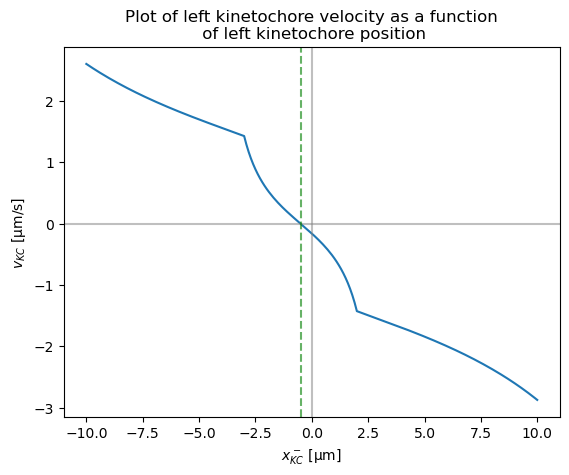

In [4]:
# Plot left kinetochore velocity versus left kinetochore position

xevi = np.linspace(-10, 10, 201)
brzine = calculate_v_KC(*parameters, xevi)  # mum/min

fig0, ax0 = plt.subplots(1, 1)
ax0.plot(xevi, brzine)
ax0.axhline(0, c="gray", alpha=0.5)
ax0.axvline(0, c="gray", alpha=0.5)
ax0.axvline(-d/2, c="green", ls="--", alpha=0.6)
#ax0.axvline(-D0/2, c="lime", ls="--", alpha=0.6)  # discontinuity in first derivative is at +-D0/2
ax0.set_title("Plot of left kinetochore velocity as a function\n of left kinetochore position")
ax0.set_xlabel(r"$x_{KC}^-\ [\mathrm{\mu m}]$")
ax0.set_ylabel(r"$v_{KC}\ [\mathrm{\mu m /s}]$")

plt.show()

In [5]:
# Apply finite difference method for integrating kinetochore velocity
t = np.linspace(0, 10, 1000)  # in minutes, time points in which to calculate v_KC and x_KC
#t2 = np.linspace(0, 10, 60000)  # use to check if number of points affects integration precision

x0 = -2.5  # left kinetochore initial position
x_KC_minus = finite_difference(calculate_v_KC, t, x0, parameters)
x_KC_plus = x_KC_minus + d

#x_KC_minus2 = finite_difference(calculate_v_KC, t2, x0, parameters)  # use to plot v_KC vs t2
#x_KC_plus2 = x_KC_minus2 + d
#x_kMT_plus = finite_difference(calculate_v_kMT_plus, t, x_KC_plus[0], parameters)
#x_kMT_minus = finite_difference(calculate_v_kMT_minus, t, x_KC_minus[0], parameters)
# upper two lines don't work because v_kMT depends on position of kinetochore and not k-fiber element
x_bMT_plus = finite_difference(lambda x: 0.5*v0, t, 0)
x_bMT_minus = finite_difference(lambda x: -0.5*v0, t, 0)

# Calculate k-fiber element position vs time using finite difference method
# Cannot use finite_difference funtion because v_kMT depends on x_KC and not x_kMT
x_kMT_plus = np.zeros(t.size)
x_kMT_minus = np.zeros(t.size)
x_kMT_plus[0] = x_KC_plus[0]  # set initial position of right k-fiber element you want to track over time
x_kMT_minus[0] = x_KC_minus[0]

for i in range(1, t.size):
    x_kMT_plus[i] = x_kMT_plus[i-1] + calculate_v_kMT_plus(*parameters, x_KC_plus[i-1]) * (t[i] - t[i-1])
    x_kMT_minus[i] = x_kMT_minus[i-1] + calculate_v_kMT_minus(*parameters, x_KC_minus[i-1]) * (t[i] - t[i-1])

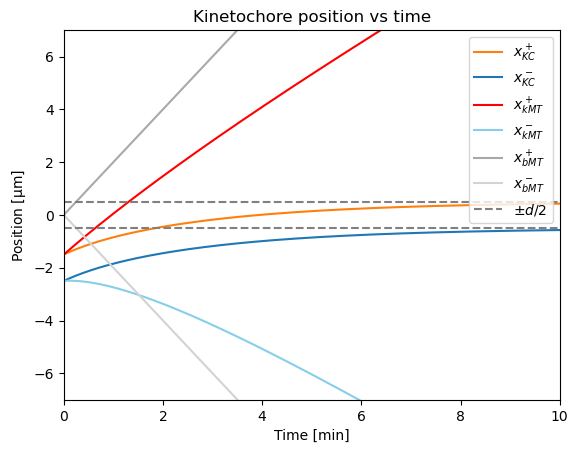

In [6]:
# Plot kinetochore position as a function of time

fig1, ax1 = plt.subplots(1, 1)
ax1.plot(t, x_KC_plus, c="C1", label="$x_{KC}^+$")
ax1.plot(t, x_KC_minus, c="C0", label="$x_{KC}^-$")
#ax1.plot(t2, x_KC_minus2, c="C0", ls="--", label="$x_{KC,2}^-$")  # plot v_KC vs t2
#ax1.plot(t2, x_KC_plus2, c="C1", ls="--", label="$x_{KC,2}^+$")
ax1.plot(t, x_kMT_plus, c="red", label="$x_{kMT}^+$")
ax1.plot(t, x_kMT_minus, c="skyblue", label="$x_{kMT}^-$")
ax1.plot(t, x_bMT_plus, c="darkgray", label="$x_{bMT}^+$")
ax1.plot(t, x_bMT_minus, c="lightgrey", label="$x_{bMT}^-$")
ax1.axhline(-d/2, c="gray", ls="--", label=r"$\pm d/2$")
ax1.axhline(d/2, c="gray", ls="--")
ax1.set_xlim(t[0], t[-1])
ax1.set_ylim(-L0/2, L0/2)
ax1.set_title("Kinetochore position vs time")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel(r"Position $[\mathrm{\mu m}]$")
plt.legend()

plt.show()

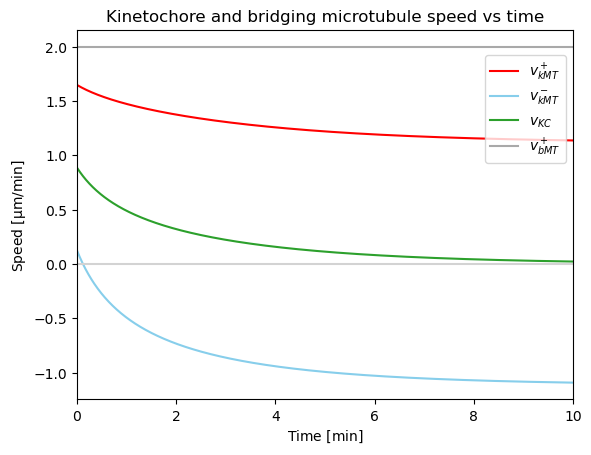

In [7]:
# Calculate and plot k-fiber velocity and kinetochore velocity

v_kMT_minus = calculate_v_kMT_minus(*parameters, x_KC_minus)
v_kMT_plus = calculate_v_kMT_plus(*parameters, x_KC_plus)
#x_KC_plus_derivative = calculate_forward_derivative(t, x_KC_plus)
#x_KC_minus_derivative = calculate_forward_derivative(t, x_KC_minus)
v_KC = calculate_v_KC(*parameters, x_KC_minus)
kMT_plus_growth = v_kMT_plus - v_KC
kMT_minus_growth = v_KC - v_kMT_minus

fig2, ax2 = plt.subplots(1, 1)
ax2.plot(t, v_kMT_plus, c="red", label="$v_{kMT}^+$")
ax2.plot(t, v_kMT_minus, c="skyblue", label="$v_{kMT}^-$")
#ax2.plot(t, kMT_minus_growth, c="C0", ls="--", label="$kMT^-$ growth")
#ax2.plot(t, kMT_plus_growth, c="C1", ls="-.", label="$kMT^+$ growth")
#ax2.plot(t, x_KC_plus_derivative, c="C2", label=r"$\frac{dx_{KC}^+}{dt}$")
#ax2.plot(t, x_KC_minus_derivative, c="C3", label=r"$\frac{dx_{KC}^-}{dt}$")
ax2.plot(t, v_KC, c="C2", ls="-", label=r"$v_{KC}$")
ax2.axhline(v0/2, c="darkgray", label="$v_{bMT}^+$")
ax2.axhline(0, c="lightgray", ls="-")
ax2.set_xlim(t[0], t[-1])
ax2.set_title("Kinetochore and bridging microtubule speed vs time")
ax2.set_xlabel(r"Time $[\text{min}]$")
ax2.set_ylabel(r"Speed [$\mathrm{\mu}$m/min]")
ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.95))

plt.show()

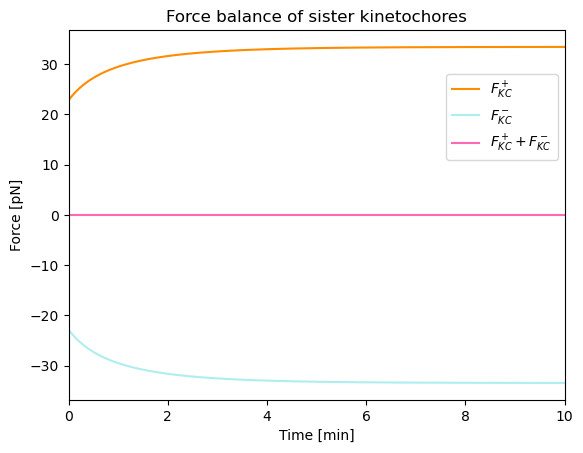

In [8]:
# Check consistency of sister kinetochore force balance
k = 100  # pN/mum --> effective interkinetochore spring constant, unused
F_KC_plus = -mu_KC * (v_KC - v_kMT_plus)  # force on right kinetochore by right k-fiber
F_KC_minus = -mu_KC * (v_KC - v_kMT_minus)  # force on left kinetochore by left k-fiber

fig3, ax3 = plt.subplots(1, 1)
ax3.plot(t, F_KC_plus, c="darkorange", label="$F_{KC}^+$")
ax3.plot(t, F_KC_minus, c="paleturquoise", label="$F_{KC}^-$")
ax3.plot(t, F_KC_plus+F_KC_minus, c="hotpink", label="$F_{KC}^+ + F_{KC}^-$")
ax3.set_xlim(t[0], t[-1])
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Force [pN]")
ax3.set_title("Force balance of sister kinetochores")
ax3.legend(loc="upper right", bbox_to_anchor=(1, 0.9))

plt.show()

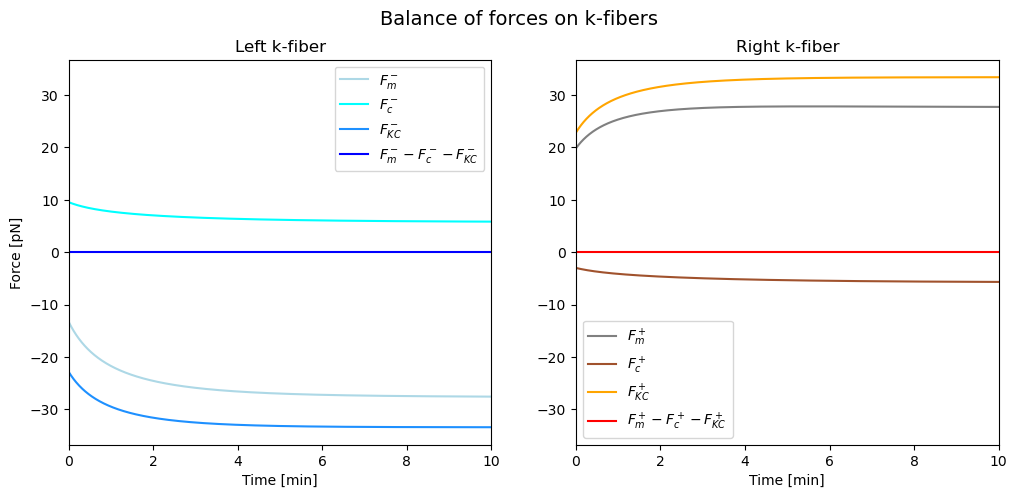

In [9]:
# Check consistency of kMT force balance (Equation 5)
D_plus = (D0/2 - x_KC_plus) * np.heaviside(D0/2 - x_KC_plus, 0)
D_minus = (D0/2 + x_KC_minus) * np.heaviside(D0/2 + x_KC_minus, 0)
F_m_plus = D_plus * n_m * f0 * (1 - (v_kMT_plus - (-v0/2))/v0)  # force of motors on right k-fiber
F_m_minus = D_minus * n_m * f0 * (-1 - (v_kMT_minus - v0/2)/v0)

L_plus = L0/2 - x_KC_plus
L_minus = L0/2 + x_KC_minus
F_c_plus = n_c * L_plus * mu_c * (v_kMT_plus - v0/2)  # force of crosslinkers on right bridging fiber
F_c_minus = n_c * L_minus * mu_c * (v_kMT_minus - (-v0/2))

fig4, ax4 = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax4[0].plot(t, F_m_minus, c="lightblue", label="$F_m^-$")
ax4[0].plot(t, F_c_minus, c="cyan", label="$F_c^-$")
ax4[0].plot(t, F_KC_minus, c="dodgerblue", label="$F_{KC}^-$")
ax4[0].plot(t, F_m_minus - F_c_minus - F_KC_minus, c="blue", label="$F_m^- - F_c^- - F_{KC}^-$")
ax4[0].set_xlim(t[0], t[-1])
ax4[0].set_xlabel("Time [min]")
ax4[0].set_ylabel("Force [pN]")
ax4[0].set_title("Left k-fiber")
ax4[0].legend()

ax4[1].plot(t, F_m_plus, c="gray", label="$F_m^+$")
ax4[1].plot(t, F_c_plus, c="sienna", label="$F_c^+$")
ax4[1].plot(t, F_KC_plus, c="orange", label="$F_{KC}^+$")
ax4[1].plot(t, F_m_plus - F_c_plus - F_KC_plus, c="red", label="$F_m^+ - F_c^+ - F_{KC}^+$")
ax4[1].set_xlim(t[0], t[-1])
ax4[1].set_xlabel("Time [min]")
#ax4[1].set_ylabel("Force [pN]")
ax4[1].set_title("Right k-fiber")
ax4[1].tick_params(labelleft=True)
ax4[1].legend()
fig4.suptitle("Balance of forces on k-fibers", fontsize=14)

plt.show()


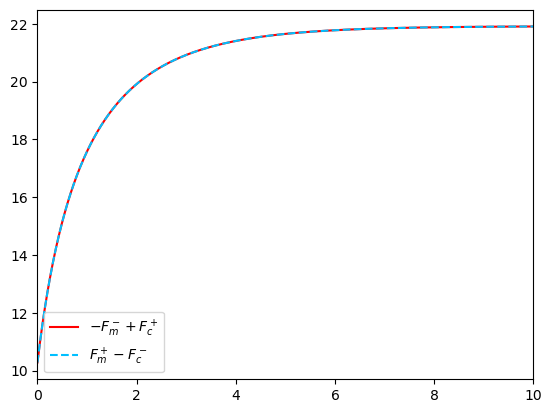

In [10]:
# Check consistency of bMT force balance (Equation 6)
# F_bMT = 0 in case v_bMT_plus = v0/2 and v_bMT_minus = -v0/2

# ne smijem staviti da je F_bMT = 0 jer ova jednadžba vrijedi prije aproksimacije v_bMT = +-v0/2

fig5, ax5 = plt.subplots(1, 1)
ax5.plot(t, -F_m_minus+F_c_plus, c="red", ls="-", label="$-F_m^- + F_c^+$")
ax5.plot(t, F_m_plus-F_c_minus, c="deepskyblue", ls="--", label="$F_m^+ - F_c^-$")
ax5.set_xlim(t[0], t[-1])
ax5.legend()

plt.show()